In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2

## With price

### Loading and preprocessing

In [4]:
df = yf.download('RELIANCE.NS', start='2018-03-01', end='2025-04-30')
if isinstance(df.columns, pd.MultiIndex):
  df.columns = df.columns.droplevel(1)

df.columns.name = None
df.index.name = "Date"
df.head()

/tmp/ipython-input-2130005269.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('RELIANCE.NS', start='2018-03-01', end='2025-04-30')
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2018-03-01,418.937714,424.017623,417.855474,419.534063,8956590
2018-03-05,408.203644,419.710733,407.099318,416.552358,12325694
2018-03-06,402.350677,413.548563,399.810738,410.368102,16019726
2018-03-07,393.030151,401.643896,392.279201,401.643896,15853546
2018-03-08,402.615723,403.963023,394.598327,396.519832,13283967


In [5]:
# preprocessing for LSTM

train = df.loc[:'2025-03-31']
test = df.loc['2025-04-01':]
# setting features and target
X_train = train.drop('Close', axis=1).values[:-1]
y_train = train['Close'].shift(-1).values[:-1]
X_test = test.drop('Close', axis=1).values[:-1]
y_test = test['Close'].shift(-1).values[:-1]
# scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))
# converting into np.array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

### building the model

In [6]:
# the model
model = keras.models.Sequential()

# first layer
model.add(keras.layers.LSTM(64,
                            return_sequences=True,
                            input_shape=(X_train.shape[1], 1),
                            dropout=0.2,
                            recurrent_dropout=0.2))

# second layer
model.add(keras.layers.LSTM(32, return_sequences=False, dropout=0.2))

# third layer
model.add(keras.layers.Dense(64, activation='relu'))

# fourth layer
model.add(keras.layers.Dropout(0.3))

# final layer (Output)
model.add(keras.layers.Dense(1))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 4, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# compiling the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError(), keras.metrics.MeanAbsoluteError(), keras.metrics.R2Score()])


### Single stock

#### training and predicting

In [8]:
# early stopping
early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=5,
                                      restore_best_weights=True)

# training
training = model.fit(X_train, y_train,
                     epochs=50,
                     batch_size=32,
                     validation_split=0.1,
                     callbacks=[early])

# predicting
pred = model.predict(X_test)
pred = scaler_y.inverse_transform(pred)   # scale back
y_test = scaler_y.inverse_transform(y_test)   # scale back y_test too

# getting metrics
lstm_mae = mae(y_test, pred)
lstm_rmse = rmse(y_test, pred)
lstm_r2 = r2(y_test, pred)

print(f'LSTM MAE: {lstm_mae}')
print(f'LSTM RMSE: {lstm_rmse}')
print(f'LSTM R2: {lstm_r2}')

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.6598 - mean_absolute_error: 0.6587 - r2_score: 0.2951 - root_mean_squared_error: 0.8057 - val_loss: 0.0688 - val_mean_absolute_error: 0.2390 - val_r2_score: 0.3841 - val_root_mean_squared_error: 0.2623
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2035 - mean_absolute_error: 0.2944 - r2_score: 0.7858 - root_mean_squared_error: 0.4499 - val_loss: 0.0576 - val_mean_absolute_error: 0.2113 - val_r2_score: 0.4848 - val_root_mean_squared_error: 0.2399
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1962 - mean_absolute_error: 0.2739 - r2_score: 0.7878 - root_mean_squared_error: 0.4428 - val_loss: 0.0911 - val_mean_absolute_error: 0.2824 - val_r2_score: 0.1846 - val_root_mean_squared_error: 0.3018
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2365 - mean_absolute_error: 0.3096 - r2_score: 0.7571 - root_mean_squared_error: 0.4859 - val_loss: 0.0445 - val_mean_absolute_error: 0.1801 - val_r2_

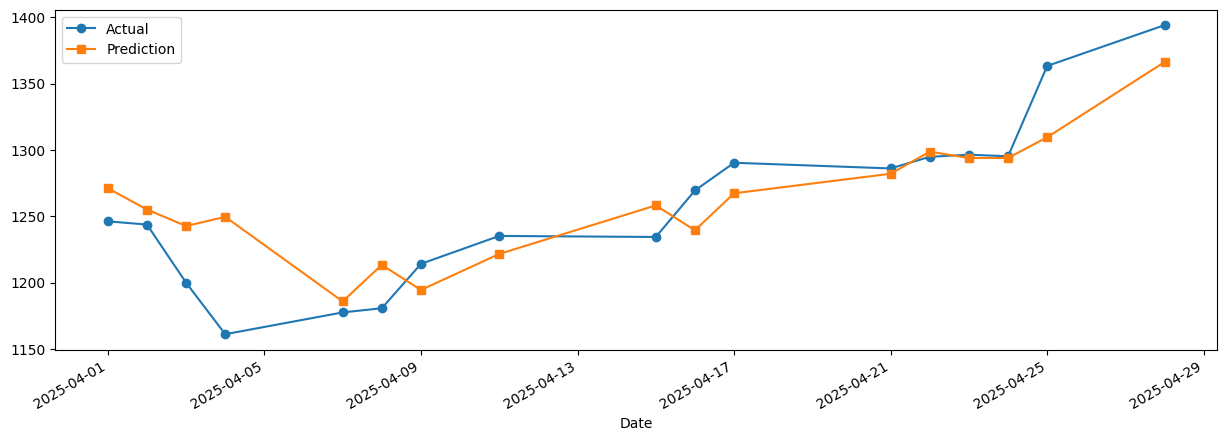

In [9]:
# plotting the predictions and tests
dates = test.index[:-1]
plt.figure(figsize=(15, 5))
pd.Series(y_test.flatten(), index=dates).plot(marker='o', label='Actual')
pd.Series(pred.flatten(), index=dates).plot(marker='s',label='Prediction')
plt.legend()
plt.savefig('lstm_pred_rel.png')
plt.show()

### 25 stocks

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def train_lstm(X_train, y_train, X_test, epochs=50, batch_size=32):
    if len(X_train.shape) == 2:
          X_train = X_train[:, np.newaxis, :]
          X_test = X_test[:, np.newaxis, :]

    # Get dimensions from the actual data
    timesteps = X_train.shape[1]
    features = X_train.shape[2]

    model = Sequential([
        LSTM(64,
              return_sequences=True,
              input_shape=(timesteps, features),
              dropout=0.2,
              recurrent_dropout=0.2),
        LSTM(32, return_sequences=False, dropout=0.2),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer="adam",
                  loss="mse",
                  metrics=[keras.metrics.RootMeanSquaredError()])
    early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=5,
                                      restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        callbacks=[early]
    )

    return model.predict(X_test, verbose=0).ravel()


In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


class LSTMexpt:
    def __init__(
        self,
        tickers,
        start,
        end,
        split_date,
        lookback=10,
        epochs=50,
        batch_size=32
    ):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.split_date = pd.Timestamp(split_date)
        self.epochs = epochs
        self.batch_size = batch_size


    def run(self):
        rows = []

        for ticker in self.tickers:
            try:
                df = yf.download(
                    ticker,
                    start=self.start,
                    end=self.end,
                    auto_adjust=True,
                    progress=False
                )

                if df.empty:
                    continue

                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.droplevel(1)

                df = df[["Open","High","Low","Volume","Close"]].dropna()

                train = df[df.index < self.split_date]
                test  = df[df.index >= self.split_date]

                X_train_raw = train[["Open","High","Low","Volume"]].values[:-1]
                y_train_raw = train["Close"].shift(-1).values[:-1]
                X_test_raw  = test[["Open","High","Low","Volume"]].values[:-1]
                y_test_raw  = test["Close"].shift(-1).values[:-1]

                sx = StandardScaler()
                sy = StandardScaler()

                X_train = sx.fit_transform(X_train_raw)
                X_test  = sx.transform(X_test_raw)
                y_train = sy.fit_transform(y_train_raw.reshape(-1,1)).ravel()


                y_pred_scaled = train_lstm(
                    X_train,
                    y_train,
                    X_test,
                    epochs=self.epochs,
                    batch_size=self.batch_size
                )

                y_pred = sy.inverse_transform(
                    y_pred_scaled.reshape(-1,1)
                ).ravel()

                y_true = y_test_raw

                rows.append({
                    "Ticker": ticker,
                    "MAE": mae(y_true, y_pred),
                    "RMSE": rmse(y_true, y_pred),
                    "R2": r2_score(y_true, y_pred)
                })

            except Exception as e:
                print(f"{ticker} failed: {e}")

        return (
            pd.DataFrame(rows)
            .set_index("Ticker")
            .sort_index()
        )


In [12]:
tickers = [
    "RELIANCE.NS",     # Large-cap
    "TCS.NS",          # Large-cap
    "HDFCBANK.NS",     # Large-cap
    "PIDILITIND.NS",   # Mid-cap
    "AUBANK.NS",       # Mid-cap
    "IEX.NS",          # Small-cap
    "MAPMYINDIA.NS",   # Small-cap
    "LTTS.NS",          # Small-cap / mid-tech
    "AAPL",     # Large-cap
    "MSFT",     # Large-cap
    "GOOGL",    # Large-cap
    "AMZN",     # Large-cap
    "NVDA",     # Large-cap
    "CRWD",     # Mid-cap
    "PLTR",     # Mid-cap
    "FSLR",     # Mid-cap
    "CELH",     # Small-cap
    "U",         # Small-cap / mid-tech
    "HSBA.L",   # Large-cap
    "BP.L",     # Large-cap
    "ULVR.L",   # Large-cap
    "AUTO.L",   # Mid-cap
    "JDW.L",    # Mid-cap
    "ASC.L",    # Small-cap
]
start = "2018-03-01"
end = "2025-04-30"
split_date = "2025-04-01"

In [14]:
!pip install xlsxwriter
exp = LSTMexpt(tickers, start, end, split_date)
df1 = exp.run()
df1.to_excel('LSTM25.xlsx', engine='xlsxwriter')
df1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.3 MB/s eta 0:00:00
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.7878 - root_mean_squared_error: 0.8858 - val_loss: 0.4567 - val_root_mean_squared_error: 0.6758
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1052 - root_mean_squared_error: 0.3240 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1855
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0828 - root_mean_squared_error: 0.2876 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1649
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0820 - root_mean_squared_error: 0.2863 - val_loss: 0.0450 - val_root_mean_squared_error: 0.2121
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0724 - root_mean_squared_error: 0.2689 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1341
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0709 - root_mean_squared_error: 0.2661 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1602
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.6771 - root_mean_squared_error: 0.8195 - val_loss: 0.5745 - val_root_mean_squared_error: 0.7580
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0832 - root_mean_squared_error: 0.2881 - val_loss: 0.1255 - val_root_mean_squared_error: 0.3542
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0729 - root_mean_squared_error: 0.2699 - val_loss: 0.1271 - val_root_mean_squared_error: 0.3564
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0679 - root_mean_squared_error: 0.2602 - val_loss: 0.1170 - val_root_mean_squared_error: 0.3421
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0624 - root_mean_squared_error: 0.2493 - val_loss: 0.0979 - val_root_mean_squared_error: 0.3128
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0589 - root_mean_squared_error: 0.2423 - val_loss: 0.1741 - val_root_mean_squared_error: 0.4173
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0654 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7262 - root_mean_squared_error: 0.8494 - val_loss: 0.1482 - val_root_mean_squared_error: 0.3849
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0826 - root_mean_squared_error: 0.2869 - val_loss: 0.1475 - val_root_mean_squared_error: 0.3840
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0724 - root_mean_squared_error: 0.2689 - val_loss: 0.1434 - val_root_mean_squared_error: 0.3786
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0764 - root_mean_squared_error: 0.2764 - val_loss: 0.1451 - val_root_mean_squared_error: 0.3809
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0685 - root_mean_squared_error: 0.2616 - val_loss: 0.1100 - val_root_mean_squared_error: 0.3317
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0688 - root_mean_squared_error: 0.2623 - val_loss: 0.0815 - val_root_mean_squared_error: 0.2855
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0693 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.6924 - root_mean_squared_error: 0.8291 - val_loss: 0.7545 - val_root_mean_squared_error: 0.8686
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0946 - root_mean_squared_error: 0.3070 - val_loss: 0.1302 - val_root_mean_squared_error: 0.3608
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0722 - root_mean_squared_error: 0.2684 - val_loss: 0.0727 - val_root_mean_squared_error: 0.2696
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0725 - root_mean_squared_error: 0.2690 - val_loss: 0.0871 - val_root_mean_squared_error: 0.2950
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0671 - root_mean_squared_error: 0.2588 - val_loss: 0.0555 - val_root_mean_squared_error: 0.2357
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0698 - root_mean_squared_error: 0.2640 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2584
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0633 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.8546 - root_mean_squared_error: 0.9211 - val_loss: 0.0312 - val_root_mean_squared_error: 0.1766
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0920 - root_mean_squared_error: 0.3030 - val_loss: 0.0225 - val_root_mean_squared_error: 0.1501
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0893 - root_mean_squared_error: 0.2988 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1412
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0792 - root_mean_squared_error: 0.2811 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1410
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0786 - root_mean_squared_error: 0.2802 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0885 - root_mean_squared_error: 0.2975 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1310
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0849 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8535 - root_mean_squared_error: 0.9228 - val_loss: 0.1167 - val_root_mean_squared_error: 0.3416
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1162 - root_mean_squared_error: 0.3399 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0734 - root_mean_squared_error: 0.2706 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0849
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0809 - root_mean_squared_error: 0.2827 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697 - root_mean_squared_error: 0.2637 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0866
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0717 - root_mean_squared_error: 0.2672 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0984
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0669 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 1.0302 - root_mean_squared_error: 1.0145 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5464 - root_mean_squared_error: 0.7367 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1157 - root_mean_squared_error: 0.3400 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1564
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0906 - root_mean_squared_error: 0.3008 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1435
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1047 - root_mean_squared_error: 0.3221 - val_loss: 0.0210 - val_root_mean_squared_error: 0.1449
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0932 - root_mean_squared_error: 0.3047 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1081 - ro

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7632 - root_mean_squared_error: 0.8723 - val_loss: 0.4099 - val_root_mean_squared_error: 0.6402
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0930 - root_mean_squared_error: 0.3047 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2112
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0711 - root_mean_squared_error: 0.2665 - val_loss: 0.0156 - val_root_mean_squared_error: 0.1251
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0658 - root_mean_squared_error: 0.2564 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1252
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0638 - root_mean_squared_error: 0.2525 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1477
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0670 - root_mean_squared_error: 0.2588 - val_loss: 0.0371 - val_root_mean_squared_error: 0.1927
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0639 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.6639 - root_mean_squared_error: 0.8120 - val_loss: 1.4611 - val_root_mean_squared_error: 1.2088
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1040 - root_mean_squared_error: 0.3217 - val_loss: 0.3034 - val_root_mean_squared_error: 0.5508
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0721 - root_mean_squared_error: 0.2683 - val_loss: 0.2169 - val_root_mean_squared_error: 0.4658
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0744 - root_mean_squared_error: 0.2722 - val_loss: 0.2262 - val_root_mean_squared_error: 0.4756
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0591 - root_mean_squared_error: 0.2430 - val_loss: 0.2200 - val_root_mean_squared_error: 0.4690
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0571 - root_mean_squared_error: 0.2386 - val_loss: 0.2079 - val_root_mean_squared_error: 0.4559
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0561 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7066 - root_mean_squared_error: 0.8374 - val_loss: 0.5978 - val_root_mean_squared_error: 0.7732
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0874 - root_mean_squared_error: 0.2950 - val_loss: 0.0736 - val_root_mean_squared_error: 0.2712
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0610 - root_mean_squared_error: 0.2466 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2892
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0695 - root_mean_squared_error: 0.2634 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0690 - root_mean_squared_error: 0.2624 - val_loss: 0.0976 - val_root_mean_squared_error: 0.3123
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504 - val_loss: 0.0257 - val_root_mean_squared_error: 0.1604
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0665 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.6832 - root_mean_squared_error: 0.8247 - val_loss: 0.6169 - val_root_mean_squared_error: 0.7854
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0805 - root_mean_squared_error: 0.2833 - val_loss: 0.1524 - val_root_mean_squared_error: 0.3904
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0677 - root_mean_squared_error: 0.2601 - val_loss: 0.1484 - val_root_mean_squared_error: 0.3853
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0724 - root_mean_squared_error: 0.2689 - val_loss: 0.1147 - val_root_mean_squared_error: 0.3387
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0687 - root_mean_squared_error: 0.2616 - val_loss: 0.0893 - val_root_mean_squared_error: 0.2989
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0648 - root_mean_squared_error: 0.2545 - val_loss: 0.1357 - val_root_mean_squared_error: 0.3683
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0581 - root_m

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.6318 - root_mean_squared_error: 0.7914 - val_loss: 0.6208 - val_root_mean_squared_error: 0.7879
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0862 - root_mean_squared_error: 0.2927 - val_loss: 0.2616 - val_root_mean_squared_error: 0.5115
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0710 - root_mean_squared_error: 0.2664 - val_loss: 0.2350 - val_root_mean_squared_error: 0.4847
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0616 - root_mean_squared_error: 0.2480 - val_loss: 0.2042 - val_root_mean_squared_error: 0.4519
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0613 - root_mean_squared_error: 0.2476 - val_loss: 0.2898 - val_root_mean_squared_error: 0.5383
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0622 - root_mean_squared_error: 0.2489 - val_loss: 0.2125 - val_root_mean_squared_error: 0.4610
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0623 - root

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.4592 - root_mean_squared_error: 0.6727 - val_loss: 3.4385 - val_root_mean_squared_error: 1.8543
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1096 - root_mean_squared_error: 0.3264 - val_loss: 0.0361 - val_root_mean_squared_error: 0.1900
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 - root_mean_squared_error: 0.1960 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2393
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0339 - root_mean_squared_error: 0.1841 - val_loss: 0.0951 - val_root_mean_squared_error: 0.3084
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0357 - root_mean_squared_error: 0.1886 - val_loss: 0.1675 - val_root_mean_squared_error: 0.4092
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0348 - root_mean_squared_error: 0.1865 - val_loss: 0.0427 - val_root_mean_squared_error: 0.2066
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0336 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.7186 - root_mean_squared_error: 0.8471 - val_loss: 1.1117 - val_root_mean_squared_error: 1.0544
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2075 - root_mean_squared_error: 0.4511 - val_loss: 0.1776 - val_root_mean_squared_error: 0.4214
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0849 - root_mean_squared_error: 0.2910 - val_loss: 0.1639 - val_root_mean_squared_error: 0.4049
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0844 - root_mean_squared_error: 0.2900 - val_loss: 0.1454 - val_root_mean_squared_error: 0.3814
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0870 - root_mean_squared_error: 0.2946 - val_loss: 0.0747 - val_root_mean_squared_error: 0.2733
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0789 - root_mean_squared_error: 0.2806 - val_loss: 0.0493 - val_root_mean_squared_error: 0.2220
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0734 - root_

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.1794 - root_mean_squared_error: 0.4232 - val_loss: 7.0845 - val_root_mean_squared_error: 2.6617
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0563 - root_mean_squared_error: 0.2356 - val_loss: 5.1356 - val_root_mean_squared_error: 2.2662
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0284 - root_mean_squared_error: 0.1682 - val_loss: 3.3339 - val_root_mean_squared_error: 1.8259
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0239 - root_mean_squared_error: 0.1539 - val_loss: 2.7006 - val_root_mean_squared_error: 1.6434
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432 - val_loss: 2.6112 - val_root_mean_squared_error: 1.6159
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0205 - root_mean_squared_error: 0.1428 - val_loss: 2.5012 - val_root_mean_squared_error: 1.5815
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0192 - root

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7822 - root_mean_squared_error: 0.8820 - val_loss: 0.3216 - val_root_mean_squared_error: 0.5671
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0890 - root_mean_squared_error: 0.2981 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1850
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1675
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0731 - root_mean_squared_error: 0.2701 - val_loss: 0.0307 - val_root_mean_squared_error: 0.1753
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0722 - root_mean_squared_error: 0.2687 - val_loss: 0.0324 - val_root_mean_squared_error: 0.1801
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0665 - root_mean_squared_error: 0.2577 - val_loss: 0.0374 - val_root_mean_squared_error: 0.1934
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0703 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.9129 - root_mean_squared_error: 0.9532 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2680
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1343 - root_mean_squared_error: 0.3657 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2292
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0933 - root_mean_squared_error: 0.3053 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0870 - root_mean_squared_error: 0.2947 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1739
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0878 - root_mean_squared_error: 0.2960 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0880 - root_mean_squared_error: 0.2964 - val_loss: 0.0499 - val_root_mean_squared_error: 0.2233
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0982 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.0214 - root_mean_squared_error: 1.0092 - val_loss: 0.3900 - val_root_mean_squared_error: 0.6245
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3913 - root_mean_squared_error: 0.6186 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0933
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1105 - root_mean_squared_error: 0.3318 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0895 - root_mean_squared_error: 0.2982 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0953 - root_mean_squared_error: 0.3084 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1093
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0830 - root_mean_squared_error: 0.2880 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1255
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0909 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.6296 - root_mean_squared_error: 0.7912 - val_loss: 1.0336 - val_root_mean_squared_error: 1.0167
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0868 - root_mean_squared_error: 0.2945 - val_loss: 0.4576 - val_root_mean_squared_error: 0.6765
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0747 - root_mean_squared_error: 0.2732 - val_loss: 0.3355 - val_root_mean_squared_error: 0.5792
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0690 - root_mean_squared_error: 0.2624 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0701 - root_mean_squared_error: 0.2647 - val_loss: 0.3534 - val_root_mean_squared_error: 0.5944
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0721 - root_mean_squared_error: 0.2682 - val_loss: 0.3799 - val_root_mean_squared_error: 0.6164
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0673 - root

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 1.0001 - root_mean_squared_error: 0.9970 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1150
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1146 - root_mean_squared_error: 0.3384 - val_loss: 0.0335 - val_root_mean_squared_error: 0.1831
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1014 - root_mean_squared_error: 0.3181 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1515
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0975 - root_mean_squared_error: 0.3121 - val_loss: 0.0265 - val_root_mean_squared_error: 0.1628
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0881 - root_mean_squared_error: 0.2967 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0952 - root_mean_squared_error: 0.3084 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1641
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.7919 - root_mean_squared_error: 0.8884 - val_loss: 0.4195 - val_root_mean_squared_error: 0.6477
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1377 - root_mean_squared_error: 0.3701 - val_loss: 0.0336 - val_root_mean_squared_error: 0.1833
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1166 - root_mean_squared_error: 0.3407 - val_loss: 0.0446 - val_root_mean_squared_error: 0.2112
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1167 - root_mean_squared_error: 0.3411 - val_loss: 0.0279 - val_root_mean_squared_error: 0.1671
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1025 - root_mean_squared_error: 0.3201 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1647
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1101 - root_mean_squared_error: 0.3310 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1707
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1044 - roo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.6352 - root_mean_squared_error: 0.7959 - val_loss: 1.2084 - val_root_mean_squared_error: 1.0993
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0912 - root_mean_squared_error: 0.3018 - val_loss: 0.2664 - val_root_mean_squared_error: 0.5161
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0758 - root_mean_squared_error: 0.2753 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3457
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0681 - root_mean_squared_error: 0.2605 - val_loss: 0.1693 - val_root_mean_squared_error: 0.4115
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0662 - root_mean_squared_error: 0.2568 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3415
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0699 - root_mean_squared_error: 0.2640 - val_loss: 0.2025 - val_root_mean_squared_error: 0.4500
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0712 - root

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.8655 - root_mean_squared_error: 0.9273 - val_loss: 0.0915 - val_root_mean_squared_error: 0.3025
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1212 - root_mean_squared_error: 0.3475 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0850
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0963 - root_mean_squared_error: 0.3098 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0896 - root_mean_squared_error: 0.2991 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0944
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0925 - root_mean_squared_error: 0.3040 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0933 - root_mean_squared_error: 0.3046 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0851 - root_me

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.8422 - root_mean_squared_error: 0.9138 - val_loss: 0.1734 - val_root_mean_squared_error: 0.4165
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0951 - root_mean_squared_error: 0.3080 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0799 - root_mean_squared_error: 0.2826 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0693 - root_mean_squared_error: 0.2632 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0965
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0759 - root_mean_squared_error: 0.2751 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0812
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0858 - root_mean_squared_error: 0.2927 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1301
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0762 - root_m

,MAE,RMSE,R2
Ticker,,,
AAPL,10.508225,12.101678,-0.159505
AMZN,6.425291,7.398768,0.079864
ASC.L,205.351230,205.902862,-91.223358
AUBANK.NS,18.283584,23.586043,0.826983
AUTO.L,11.665904,17.872511,0.722051
BP.L,12.851910,19.073617,0.328544
CELH,0.620250,0.810559,0.240734
CRWD,20.998545,24.894450,0.374638
FSLR,11.157676,13.064349,-3.693955


## with log return

### single stock

In [24]:
class LogReturnLSTMExperiment:
    def __init__(self, ticker, start, end, split_date, lookback=20, epochs=50, batch_size=32):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.split_date = pd.Timestamp(split_date)
        self.lookback = lookback
        self.epochs = epochs
        self.batch_size = batch_size

    def make_sequences(self, data, target):
        X, y = [], []
        for i in range(len(data) - self.lookback):
            X.append(data[i : i + self.lookback])
            y.append(target[i + self.lookback])
        return np.array(X), np.array(y)

    def load_data(self):
        df = yf.download(
            self.ticker,
            start=self.start,
            end=self.end,
            auto_adjust=True,
            progress=False
        )

        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1)

        df.index.name = "Date"
        df.columns.name = None

        df["log_ret"] = np.log(df["Close"]).diff()

        for col in ["Open", "High", "Low", "Volume"]:
            df[f"{col}_lag1"] = df[col].shift(1)

        return df.dropna()

    def run(self):
        df = self.load_data()
        features = ["Open_lag1", "High_lag1", "Low_lag1", "Volume_lag1"]


        train_df = df[df.index < self.split_date]
        scaler_X = StandardScaler().fit(train_df[features])
        scaler_y = StandardScaler().fit(train_df[["log_ret"]])

        full_X = scaler_X.transform(df[features])
        full_y = scaler_y.transform(df[["log_ret"]]).ravel()


        X_seq, y_seq = self.make_sequences(full_X, full_y)


        split_idx = df.index.get_loc(df[df.index >= self.split_date].index[0])
        # Adjust for the lookback offset
        split_seq_idx = split_idx - self.lookback

        X_train, y_train = X_seq[:split_seq_idx], y_seq[:split_seq_idx]
        X_test, y_test = X_seq[split_seq_idx:], y_seq[split_seq_idx:]


        y_pred_scaled = train_lstm(
            X_train, y_train, X_test,
            epochs=self.epochs, batch_size=self.batch_size
        )


        y_pred_logret = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

        # Match lengths for price reconstruction
        actual_test_df = df.iloc[split_idx:]
        prev_prices = actual_test_df["Close"].shift(1).values
        # The first prev_price for the first test day is actually the last day of March
        # We get that from the row exactly before split_idx
        first_prev_price = df.iloc[split_idx - 1]["Close"]
        prev_prices[0] = first_prev_price

        price_pred = prev_prices * np.exp(y_pred_logret)

        return pd.DataFrame({
            "dates": actual_test_df.index,
            "y_true_logret": actual_test_df["log_ret"].values,
            "y_pred_logret": y_pred_logret,
            "y_true_price": actual_test_df["Close"].values,
            "y_pred_price": price_pred
        }), actual_test_df['Close'].values, price_pred

In [18]:
exp = LogReturnLSTMExperiment(
    'RELIANCE.NS',
    start='2018-03-01',
    end='2025-04-30',
    split_date='2025-04-01'
)
out = exp.run()
log_mae = mae(out["y_true_price"], out["y_pred_price"])
log_rmse = rmse(out['y_true_price'], out['y_pred_price'])
log_r2 = r2(out['y_true_price'], out['y_pred_price'])

print(f'Log Return LSTM MAE: {log_mae}')
print(f'Log Return LSTM RMSE: {log_rmse}')
print(f'Log Return LSTM R2: {log_r2}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.0283 - root_mean_squared_error: 1.0120 - val_loss: 0.5022 - val_root_mean_squared_error: 0.7086
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.1090 - root_mean_squared_error: 1.0499 - val_loss: 0.4910 - val_root_mean_squared_error: 0.7007
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.9448 - root_mean_squared_error: 0.9686 - val_loss: 0.4836 - val_root_mean_squared_error: 0.6954
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.2490 - root_mean_squared_error: 1.1144 - val_loss: 0.4796 - val_root_mean_squared_error: 0.6925
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1478 - root_mean_squared_error: 1.0685 - val_loss: 0.4868 - val_root_mean_squared_error: 0.6977
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.2331 - root_mean_squared_error: 1.1063 - val_loss: 0.4874 - val_root_mean_squared_error: 0.6981
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss:

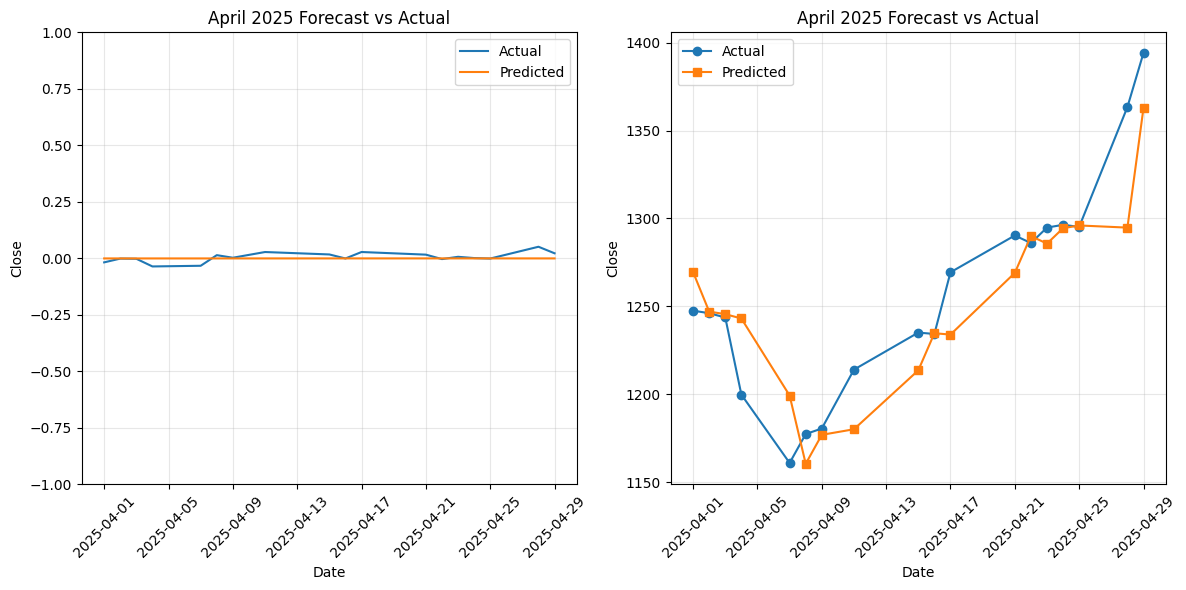

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
# plotting

# returns
axes[0].plot(out["dates"], out["y_true_logret"], label="Actual")
axes[0].plot(out["dates"], out["y_pred_logret"], label="Predicted")
axes[0].set_ylim(-1,1)
axes[0].set_xlabel('Date')
axes[0].set_ylabel(f'Close')
axes[0].set_title('April 2025 Forecast vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# prices
axes[1].plot(out["dates"], out["y_true_price"], marker='o', label="Actual")
axes[1].plot(out["dates"], out["y_pred_price"], marker='s', label="Predicted")
axes[1].set_xlabel('Date')
axes[1].set_ylabel(f'Close')
axes[1].set_title('April 2025 Forecast vs Actual')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)



plt.tight_layout()
plt.show()


### 25 stocks

In [25]:
class MultiStockLogReturnLSTM:
    def __init__(self, tickers, start, end, split_date, **model_kwargs):
        self.tickers = tickers
        self.start = start
        self.end = end
        self.split_date = split_date
        self.model_kwargs = model_kwargs

    def run(self):
        rows = []

        for ticker in self.tickers:
            try:
                exp = LogReturnLSTMExperiment(
                    ticker=ticker,
                    start=self.start,
                    end=self.end,
                    split_date=self.split_date,
                    **self.model_kwargs
                )

                _, y_true, y_pred, = exp.run()

                rows.append({
                    "Ticker": ticker,
                    "MAE":  mae(y_true, y_pred),
                    "RMSE": rmse(y_true, y_pred),
                    "R2":   r2(y_true, y_pred)
                })

                print(f"{ticker} done")

            except Exception as e:
                print(f"{ticker} failed: {e}")

        return pd.DataFrame(rows)


In [26]:
exp = MultiStockLogReturnLSTM(tickers, start, end, split_date)
df1 = exp.run()
df1.to_excel('LSTM25_logret.xlsx', engine='xlsxwriter')
df1

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 1.1232 - root_mean_squared_error: 1.0580 - val_loss: 0.4831 - val_root_mean_squared_error: 0.6951
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0378 - root_mean_squared_error: 1.0175 - val_loss: 0.4771 - val_root_mean_squared_error: 0.6908
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 1.0207 - root_mean_squared_error: 1.0088 - val_loss: 0.4911 - val_root_mean_squared_error: 0.7008
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.1258 - root_mean_squared_error: 1.0603 - val_loss: 0.4815 - val_root_mean_squared_error: 0.6939
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0066 - root_mean_squared_error: 1.0021 - val_loss: 0.4837 - val_root_mean_squared_error: 0.6955
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.9992 - root_mean_squared_error: 0.9984 - val_loss: 0.4777 - val_root_mean_squared_error: 0.6912
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0906 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 1.1203 - root_mean_squared_error: 1.0570 - val_loss: 0.7201 - val_root_mean_squared_error: 0.8486
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0197 - root_mean_squared_error: 1.0093 - val_loss: 0.7185 - val_root_mean_squared_error: 0.8476
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0655 - root_mean_squared_error: 1.0319 - val_loss: 0.7152 - val_root_mean_squared_error: 0.8457
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9827 - root_mean_squared_error: 0.9910 - val_loss: 0.7214 - val_root_mean_squared_error: 0.8494
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.0555 - root_mean_squared_error: 1.0260 - val_loss: 0.7286 - val_root_mean_squared_error: 0.8536
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.0697 - root_mean_squared_error: 1.0311 - val_loss: 0.7191 - val_root_mean_squared_error: 0.8480
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0224 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.8943 - root_mean_squared_error: 0.9403 - val_loss: 0.5288 - val_root_mean_squared_error: 0.7272
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0794 - root_mean_squared_error: 1.0380 - val_loss: 0.5398 - val_root_mean_squared_error: 0.7347
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0111 - root_mean_squared_error: 1.0041 - val_loss: 0.5466 - val_root_mean_squared_error: 0.7393
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.1609 - root_mean_squared_error: 1.0744 - val_loss: 0.5306 - val_root_mean_squared_error: 0.7284
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0210 - root_mean_squared_error: 1.0097 - val_loss: 0.5366 - val_root_mean_squared_error: 0.7325
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.9469 - root_mean_squared_error: 0.9718 - val_loss: 0.5315 - val_root_mean_squared_error: 0.7290
HDFCBANK.NS done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.2027 - root_mean_squared_error: 1.0935 - val_loss: 0.6370 - val_root_mean_squared_error: 0.7981
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0726 - root_mean_squared_error: 1.0344 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.1329 - root_mean_squared_error: 1.0634 - val_loss: 0.6392 - val_root_mean_squared_error: 0.7995
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1977 - root_mean_squared_error: 1.0870 - val_loss: 0.6412 - val_root_mean_squared_error: 0.8007
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9969 - root_mean_squared_error: 0.9960 - val_loss: 0.6351 - val_root_mean_squared_error: 0.7969
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.1040 - root_mean_squared_error: 1.0500 - val_loss: 0.6357 - val_root_mean_squared_error: 0.7973
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.0651 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.1179 - root_mean_squared_error: 1.0564 - val_loss: 0.6778 - val_root_mean_squared_error: 0.8233
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.1078 - root_mean_squared_error: 1.0495 - val_loss: 0.6855 - val_root_mean_squared_error: 0.8279
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.0798 - root_mean_squared_error: 1.0381 - val_loss: 0.6865 - val_root_mean_squared_error: 0.8285
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.1353 - root_mean_squared_error: 1.0632 - val_loss: 0.6769 - val_root_mean_squared_error: 0.8227
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.0544 - root_mean_squared_error: 1.0253 - val_loss: 0.6842 - val_root_mean_squared_error: 0.8272
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.0783 - root_mean_squared_error: 1.0379 - val_loss: 0.6853 - val_root_mean_squared_error: 0.8278
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.0562 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 1.0035 - root_mean_squared_error: 1.0001 - val_loss: 1.0600 - val_root_mean_squared_error: 1.0296
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.9895 - root_mean_squared_error: 0.9931 - val_loss: 1.0328 - val_root_mean_squared_error: 1.0162
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.9058 - root_mean_squared_error: 0.9499 - val_loss: 1.0320 - val_root_mean_squared_error: 1.0159
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0353 - root_mean_squared_error: 1.0161 - val_loss: 1.0310 - val_root_mean_squared_error: 1.0154
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 1.0087 - root_mean_squared_error: 1.0031 - val_loss: 1.0285 - val_root_mean_squared_error: 1.0142
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0142 - root_mean_squared_error: 1.0068 - val_loss: 1.0276 - val_root_mean_squared_error: 1.0137
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.9886 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.8969 - root_mean_squared_error: 0.9436 - val_loss: 0.8017 - val_root_mean_squared_error: 0.8954
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.8953 - root_mean_squared_error: 0.9433 - val_loss: 0.8021 - val_root_mean_squared_error: 0.8956
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0528 - root_mean_squared_error: 1.0245 - val_loss: 0.8007 - val_root_mean_squared_error: 0.8948
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0880 - root_mean_squared_error: 1.0400 - val_loss: 0.8001 - val_root_mean_squared_error: 0.8945
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.1678 - root_mean_squared_error: 1.0745 - val_loss: 0.8006 - val_root_mean_squared_error: 0.8948
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.1114 - root_mean_squared_error: 1.0498 - val_loss: 0.8010 - val_root_mean_squared_error: 0.8950
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.9597 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 1.0187 - root_mean_squared_error: 1.0082 - val_loss: 0.7705 - val_root_mean_squared_error: 0.8778
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0008 - root_mean_squared_error: 0.9995 - val_loss: 0.7714 - val_root_mean_squared_error: 0.8783
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1873 - root_mean_squared_error: 1.0867 - val_loss: 0.7737 - val_root_mean_squared_error: 0.8796
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.9904 - root_mean_squared_error: 0.9948 - val_loss: 0.7809 - val_root_mean_squared_error: 0.8837
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0721 - root_mean_squared_error: 1.0347 - val_loss: 0.8032 - val_root_mean_squared_error: 0.8962
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.0588 - root_mean_squared_error: 1.0277 - val_loss: 0.7744 - val_root_mean_squared_error: 0.8800
LTTS.NS done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 1.0898 - root_mean_squared_error: 1.0435 - val_loss: 0.5898 - val_root_mean_squared_error: 0.7680
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.1449 - root_mean_squared_error: 1.0688 - val_loss: 0.6033 - val_root_mean_squared_error: 0.7767
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.0597 - root_mean_squared_error: 1.0278 - val_loss: 0.5869 - val_root_mean_squared_error: 0.7661
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0384 - root_mean_squared_error: 1.0185 - val_loss: 0.5870 - val_root_mean_squared_error: 0.7662
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1131 - root_mean_squared_error: 1.0533 - val_loss: 0.5853 - val_root_mean_squared_error: 0.7651
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 1.1140 - root_mean_squared_error: 1.0547 - val_loss: 0.6055 - val_root_mean_squared_error: 0.7782
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9108 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 1.0685 - root_mean_squared_error: 1.0329 - val_loss: 0.6228 - val_root_mean_squared_error: 0.7892
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.0956 - root_mean_squared_error: 1.0457 - val_loss: 0.6179 - val_root_mean_squared_error: 0.7861
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0168 - root_mean_squared_error: 1.0069 - val_loss: 0.6179 - val_root_mean_squared_error: 0.7861
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0347 - root_mean_squared_error: 1.0165 - val_loss: 0.6243 - val_root_mean_squared_error: 0.7901
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.0480 - root_mean_squared_error: 1.0229 - val_loss: 0.6283 - val_root_mean_squared_error: 0.7927
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0802 - root_mean_squared_error: 1.0377 - val_loss: 0.6234 - val_root_mean_squared_error: 0.7895
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.9192 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 1.0336 - root_mean_squared_error: 1.0159 - val_loss: 0.9857 - val_root_mean_squared_error: 0.9928
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.9776 - root_mean_squared_error: 0.9882 - val_loss: 0.9586 - val_root_mean_squared_error: 0.9791
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.0558 - root_mean_squared_error: 1.0265 - val_loss: 0.9465 - val_root_mean_squared_error: 0.9729
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9711 - root_mean_squared_error: 0.9852 - val_loss: 0.9534 - val_root_mean_squared_error: 0.9764
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0818 - root_mean_squared_error: 1.0372 - val_loss: 0.9651 - val_root_mean_squared_error: 0.9824
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.9560 - root_mean_squared_error: 0.9769 - val_loss: 0.9578 - val_root_mean_squared_error: 0.9787
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9425 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 1.0503 - root_mean_squared_error: 1.0245 - val_loss: 0.8072 - val_root_mean_squared_error: 0.8985
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0388 - root_mean_squared_error: 1.0189 - val_loss: 0.7994 - val_root_mean_squared_error: 0.8941
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 1.0465 - root_mean_squared_error: 1.0220 - val_loss: 0.7989 - val_root_mean_squared_error: 0.8938
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0939 - root_mean_squared_error: 1.0439 - val_loss: 0.8051 - val_root_mean_squared_error: 0.8973
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0740 - root_mean_squared_error: 1.0360 - val_loss: 0.8033 - val_root_mean_squared_error: 0.8963
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.9157 - root_mean_squared_error: 0.9559 - val_loss: 0.8029 - val_root_mean_squared_error: 0.8961
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0602 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.9252 - root_mean_squared_error: 0.9603 - val_loss: 1.2530 - val_root_mean_squared_error: 1.1194
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9770 - root_mean_squared_error: 0.9873 - val_loss: 1.2355 - val_root_mean_squared_error: 1.1115
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.9250 - root_mean_squared_error: 0.9607 - val_loss: 1.2849 - val_root_mean_squared_error: 1.1335
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.9748 - root_mean_squared_error: 0.9868 - val_loss: 1.2617 - val_root_mean_squared_error: 1.1233
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.9609 - root_mean_squared_error: 0.9790 - val_loss: 1.2567 - val_root_mean_squared_error: 1.1210
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9638 - root_mean_squared_error: 0.9805 - val_loss: 1.2757 - val_root_mean_squared_error: 1.1295
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9205 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.9724 - root_mean_squared_error: 0.9848 - val_loss: 0.6484 - val_root_mean_squared_error: 0.8052
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0485 - root_mean_squared_error: 1.0223 - val_loss: 0.6809 - val_root_mean_squared_error: 0.8252
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0742 - root_mean_squared_error: 1.0329 - val_loss: 0.6592 - val_root_mean_squared_error: 0.8119
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0187 - root_mean_squared_error: 1.0081 - val_loss: 0.6662 - val_root_mean_squared_error: 0.8162
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9870 - root_mean_squared_error: 0.9930 - val_loss: 0.6523 - val_root_mean_squared_error: 0.8076
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9608 - root_mean_squared_error: 0.9799 - val_loss: 0.6780 - val_root_mean_squared_error: 0.8234
CRWD done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - loss: 0.9611 - root_mean_squared_error: 0.9797 - val_loss: 1.3344 - val_root_mean_squared_error: 1.1551
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0458 - root_mean_squared_error: 1.0220 - val_loss: 1.2989 - val_root_mean_squared_error: 1.1397
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.0110 - root_mean_squared_error: 1.0051 - val_loss: 1.3004 - val_root_mean_squared_error: 1.1404
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.0508 - root_mean_squared_error: 1.0217 - val_loss: 1.3013 - val_root_mean_squared_error: 1.1408
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9013 - root_mean_squared_error: 0.9484 - val_loss: 1.3989 - val_root_mean_squared_error: 1.1827
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8823 - root_mean_squared_error: 0.9362 - val_loss: 1.5010 - val_root_mean_squared_error: 1.2251
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.9238 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.9552 - root_mean_squared_error: 0.9736 - val_loss: 1.0863 - val_root_mean_squared_error: 1.0423
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0404 - root_mean_squared_error: 1.0189 - val_loss: 1.0923 - val_root_mean_squared_error: 1.0451
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.0316 - root_mean_squared_error: 1.0120 - val_loss: 1.0864 - val_root_mean_squared_error: 1.0423
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9834 - root_mean_squared_error: 0.9913 - val_loss: 1.0927 - val_root_mean_squared_error: 1.0453
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.9506 - root_mean_squared_error: 0.9728 - val_loss: 1.0891 - val_root_mean_squared_error: 1.0436
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0397 - root_mean_squared_error: 1.0190 - val_loss: 1.0961 - val_root_mean_squared_error: 1.0469
FSLR done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.9977 - root_mean_squared_error: 0.9964 - val_loss: 0.8890 - val_root_mean_squared_error: 0.9429
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.9391 - root_mean_squared_error: 0.9669 - val_loss: 0.8946 - val_root_mean_squared_error: 0.9458
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0009 - root_mean_squared_error: 0.9999 - val_loss: 0.9044 - val_root_mean_squared_error: 0.9510
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.9315 - root_mean_squared_error: 0.9627 - val_loss: 0.9196 - val_root_mean_squared_error: 0.9589
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 1.1124 - root_mean_squared_error: 1.0477 - val_loss: 0.9026 - val_root_mean_squared_error: 0.9500
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.1095 - root_mean_squared_error: 1.0517 - val_loss: 0.9025 - val_root_mean_squared_error: 0.9500
CELH done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 1.0853 - root_mean_squared_error: 1.0390 - val_loss: 0.9947 - val_root_mean_squared_error: 0.9973
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9314 - root_mean_squared_error: 0.9644 - val_loss: 0.9927 - val_root_mean_squared_error: 0.9964
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8784 - root_mean_squared_error: 0.9367 - val_loss: 0.9956 - val_root_mean_squared_error: 0.9978
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9936 - root_mean_squared_error: 0.9943 - val_loss: 0.9868 - val_root_mean_squared_error: 0.9934
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9140 - root_mean_squared_error: 0.9554 - val_loss: 0.9901 - val_root_mean_squared_error: 0.9951
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9480 - root_mean_squared_error: 0.9724 - val_loss: 0.9917 - val_root_mean_squared_error: 0.9958
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0362 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 1.0659 - root_mean_squared_error: 1.0321 - val_loss: 0.6861 - val_root_mean_squared_error: 0.8283
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0210 - root_mean_squared_error: 1.0100 - val_loss: 0.6958 - val_root_mean_squared_error: 0.8342
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 1.0328 - root_mean_squared_error: 1.0154 - val_loss: 0.6852 - val_root_mean_squared_error: 0.8278
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.8991 - root_mean_squared_error: 0.9458 - val_loss: 0.7030 - val_root_mean_squared_error: 0.8384
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0217 - root_mean_squared_error: 1.0105 - val_loss: 0.6966 - val_root_mean_squared_error: 0.8347
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9885 - root_mean_squared_error: 0.9938 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.9926 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 1.0173 - root_mean_squared_error: 1.0075 - val_loss: 0.5467 - val_root_mean_squared_error: 0.7394
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0277 - root_mean_squared_error: 1.0101 - val_loss: 0.5510 - val_root_mean_squared_error: 0.7423
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.9867 - root_mean_squared_error: 0.9925 - val_loss: 0.5465 - val_root_mean_squared_error: 0.7393
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 1.0024 - root_mean_squared_error: 0.9993 - val_loss: 0.5451 - val_root_mean_squared_error: 0.7383
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 1.1058 - root_mean_squared_error: 1.0489 - val_loss: 0.5424 - val_root_mean_squared_error: 0.7365
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.1346 - root_mean_squared_error: 1.0601 - val_loss: 0.5444 - val_root_mean_squared_error: 0.7379
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0109 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 1.0832 - root_mean_squared_error: 1.0392 - val_loss: 0.8194 - val_root_mean_squared_error: 0.9052
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.9774 - root_mean_squared_error: 0.9867 - val_loss: 0.8120 - val_root_mean_squared_error: 0.9011
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.9774 - root_mean_squared_error: 0.9877 - val_loss: 0.8255 - val_root_mean_squared_error: 0.9086
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.9010 - root_mean_squared_error: 0.9466 - val_loss: 0.8205 - val_root_mean_squared_error: 0.9058
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.9994 - root_mean_squared_error: 0.9995 - val_loss: 0.8206 - val_root_mean_squared_error: 0.9059
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0538 - root_mean_squared_error: 1.0245 - val_loss: 0.8175 - val_root_mean_squared_error: 0.9042
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0119 - r

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.1512 - root_mean_squared_error: 1.0701 - val_loss: 0.4000 - val_root_mean_squared_error: 0.6325
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.0951 - root_mean_squared_error: 1.0445 - val_loss: 0.4054 - val_root_mean_squared_error: 0.6367
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 1.1454 - root_mean_squared_error: 1.0653 - val_loss: 0.4511 - val_root_mean_squared_error: 0.6717
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.9506 - root_mean_squared_error: 0.9736 - val_loss: 0.4026 - val_root_mean_squared_error: 0.6345
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0738 - root_mean_squared_error: 1.0357 - val_loss: 0.4032 - val_root_mean_squared_error: 0.6350
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 1.2544 - root_mean_squared_error: 1.1141 - val_loss: 0.4023 - val_root_mean_squared_error: 0.6343
AUTO.L done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 1.0783 - root_mean_squared_error: 1.0370 - val_loss: 0.4260 - val_root_mean_squared_error: 0.6527
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 1.2955 - root_mean_squared_error: 1.1323 - val_loss: 0.4290 - val_root_mean_squared_error: 0.6550
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.0178 - root_mean_squared_error: 1.0081 - val_loss: 0.4306 - val_root_mean_squared_error: 0.6562
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.0925 - root_mean_squared_error: 1.0447 - val_loss: 0.4287 - val_root_mean_squared_error: 0.6547
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1478 - root_mean_squared_error: 1.0671 - val_loss: 0.4377 - val_root_mean_squared_error: 0.6616
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0749 - root_mean_squared_error: 1.0357 - val_loss: 0.4272 - val_root_mean_squared_error: 0.6536
JDW.L done
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 1.1191 - root_mean_squared_error: 1.0476 - val_loss: 0.4911 - val_root_mean_squared_error: 0.7008
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.0310 - root_mean_squared_error: 1.0117 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6996
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.0529 - root_mean_squared_error: 1.0252 - val_loss: 0.4917 - val_root_mean_squared_error: 0.7012
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1634 - root_mean_squared_error: 1.0721 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6997
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.9449 - root_mean_squared_error: 0.9701 - val_loss: 0.4912 - val_root_mean_squared_error: 0.7009
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.9917 - root_mean_squared_error: 0.9919 - val_loss: 0.4901 - val_root_mean_squared_error: 0.7001
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8915 - r

,Ticker,MAE,RMSE,R2
0,RELIANCE.NS,19.733592,27.146189,0.794348
1,TCS.NS,38.148976,52.835620,0.705503
2,HDFCBANK.NS,12.528890,15.685251,0.778172
3,PIDILITIND.NS,14.541082,17.535369,0.800496
4,AUBANK.NS,14.076194,18.612401,0.895558
5,IEX.NS,2.238146,2.739733,0.823043
6,MAPMYINDIA.NS,22.941170,27.600593,0.591974
7,LTTS.NS,89.950535,116.466998,0.471578
8,AAPL,6.619617,9.429707,0.393548
9,MSFT,7.569676,10.791564,0.244654
